In [60]:
from matplotlib import pyplot as plt
%matplotlib inline

In [61]:
# Extract features from XMLs
# We added as many unique "commands" as we could find, as well as the number of "commands" and "processes"

import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse

import util

TRAIN_DIR = "train"
TEST_DIR = "test"

call_set = set([])

def add_to_set(tree):
    for el in tree.iter():
        call = el.tag
        call_set.add(call)

def create_data_matrix(start_index, end_index, direc):
    X = None
    classes = []
    ids = [] 
    i = -1
    for datafile in os.listdir(direc):
        if datafile == '.DS_Store':
            continue

        i += 1
        if i < start_index:
            continue 
        if i >= end_index:
            break
        
        # extract id and true class (if available) from filename
        id_str, clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))

        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)

        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        add_to_set(tree)
        X_row = call_feats(tree)
        _nProcesses = nProcesses(tree)
        _nCommands = nCommands(tree)
        this_row = np.hstack((X_row, _nProcesses, _nCommands))
        if X is None:
            X = this_row 
        else:
            X = np.vstack((X, this_row))

    return X, np.array(classes), ids

def call_feats(tree):
    calls = ['all_section', 'bind_socket', 'check_for_debugger',
       'com_create_instance', 'com_get_class_object', 'connect',
       'connect_socket', 'copy_file', 'create_directory', 'create_file',
       'create_key', 'create_mutex', 'create_open_file', 'create_process',
       'create_socket', 'create_thread', 'create_window', 'delete_file',
       'delete_key', 'delete_value', 'destroy_window', 'dump_line',
       'enum_keys', 'enum_processes', 'enum_values', 'enum_window',
       'find_file', 'find_window', 'get_computer_name',
       'get_file_attributes', 'get_host_by_name', 'get_system_directory',
       'get_system_time', 'get_username', 'get_windows_directory',
       'impersonate_user', 'kill_process', 'load_dll', 'load_image',
       'open_file', 'open_key', 'open_mutex', 'open_process',
       'open_scmanager', 'open_service', 'open_url', 'process',
       'processes', 'query_value', 'read_section', 'read_value',
       'recv_socket', 'remove_directory', 'send_socket',
       'set_file_attributes', 'set_file_time', 'set_value',
       'set_windows_hook', 'show_window', 'sleep', 'thread',
       'trimmed_bytes', 'vm_protect', 'write_value']

    call_counter = {}
    for el in tree.iter():
        call = el.tag
        if call not in call_counter:
            call_counter[call] = 0
        else:
            call_counter[call] += 1

    call_feat_array = np.zeros(len(calls))
    for i in range(len(calls)):
        call = calls[i]
        call_feat_array[i] = 0
        if call in call_counter:
            call_feat_array[i] = call_counter[call]

    return call_feat_array

def nProcesses(tree) :
    root = tree.getroot()
    process = []
    for child in root :
        if type(child) is not str :
            if 'filename' in child.attrib.keys() :
                process.append(child.attrib['filename'])
        
    return len(process)

def nCommands(tree) :
    commands = []
    for el in tree.iter() :
        commands.append(el.tag)
        
    return len(commands)

In [62]:
'''# Process the training data

%%time
X_train, y_train, train_ids = create_data_matrix(0, 3086, TRAIN_DIR)
print X_train.shape
print y_train.shape'''

'# Process the training data\n\n%%time\nX_train, y_train, train_ids = create_data_matrix(0, 3086, TRAIN_DIR)\nprint X_train.shape\nprint y_train.shape'

In [63]:
'''# Process the test data

%%time
X_test, y_test, test_ids = create_data_matrix(0, 3724, TEST_DIR)
print X_test.shape
print y_test.shape'''

'# Process the test data\n\n%%time\nX_test, y_test, test_ids = create_data_matrix(0, 3724, TEST_DIR)\nprint X_test.shape\nprint y_test.shape'

In [64]:
'''# Export just in case the kernel crashes

np.save('save/X_train',X_train)
np.save('save/X_test',X_test)
np.save('save/y_train',y_train)
np.save('save/y_test',y_test)
np.save('save/train_ids',train_ids)
np.save('save/test_ids',test_ids)'''

"# Export just in case the kernel crashes\n\nnp.save('save/X_train',X_train)\nnp.save('save/X_test',X_test)\nnp.save('save/y_train',y_train)\nnp.save('save/y_test',y_test)\nnp.save('save/train_ids',train_ids)\nnp.save('save/test_ids',test_ids)"

In [122]:
# Re-import the saved train/test files

X_train = np.load('save/X_train.npy')
X_test = np.load('save/X_test.npy')
y_train = np.load('save/y_train.npy')
y_test = np.load('save/y_test.npy')
train_ids = np.load('save/train_ids.npy')
test_ids = np.load('save/test_ids.npy')

In [124]:
import sys
import random

# Add some jitter to an array to prevent overlapping
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# Plot accuracy scores so we can visualize errors
def accuracy_score(arr1, arr2, display=True) :
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    
    if arr1.shape == arr2.shape :
        if display == True:
            print 'Accuracy: ' + str(len(np.where(arr1 == arr2)[0])/float(arr1.shape[0]))
    
    plt.scatter(rand_jitter(arr1), rand_jitter(arr2), alpha=0.1);
    plt.xlabel('Predictions');
    plt.ylabel('True classification');

In [67]:
# Because the values of each column are so severely right skewed, we tried to normalize the columns a bit ...

def normalize1(array) :
    useArray = array[0:63]
    otherCols = array[64:66]
    rowsum = np.sum(useArray)
    newrow = np.append(np.array([el/float(rowsum) for el in useArray]), otherCols)
    return np.append(newrow, rowsum)

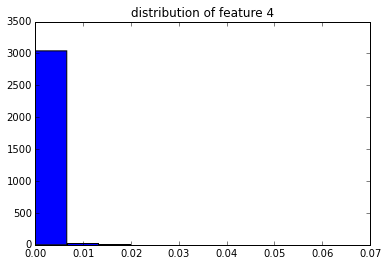

In [68]:
# Visualize different effects ...
mat_viz = np.apply_along_axis(normalize1, 1, X_train)

random_num = random.randint(0, 63)
plt.hist(mat_viz[:,random_num]);
plt.title('distribution of feature ' + str(random_num));

Baseline (predicting all as 'none')
Accuracy: 0.52138690862
None


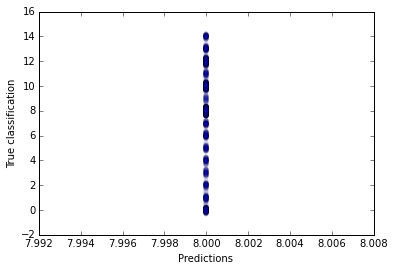

In [69]:
# Check the accuracy of the baseline (predicting all 8)

baseline = [8] * y_train.shape[0]
print "Baseline (predicting all as 'none')"
print accuracy_score(baseline, y_train, display=True)

In [120]:
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cross_validation import cross_val_score, KFold
from sklearn import cross_validation as cv
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

Logistic Regression average accuracy: 0.738494542441

Sample Logistic Regression:


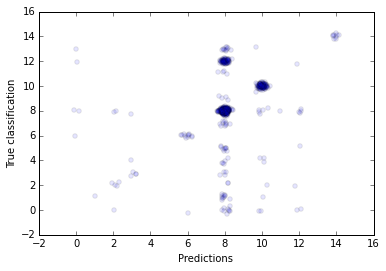

In [125]:
scores = []
LR = linear_model.LogisticRegression()

for train, test in KFold(len(y_train), n_folds=5):
    xtrain, xtest, ytrain, ytest = X_train[train], X_train[test], y_train[train], y_train[test]
    
    b = SelectKBest()
    b.fit(xtrain, ytrain)
    xtrain = xtrain[:, b.get_support()]
    xtest = xtest[:, b.get_support()]

    LR.fit(xtrain, ytrain)
    scores.append(LR.score(xtest, ytest))

print "Logistic Regression average accuracy:", np.mean(scores)

print "\nSample Logistic Regression:"
lrpred = LR.predict(xtest)
accuracy_score(lrpred, ytest, display=False)

Based on the rather low accuracy and the above plot, it seems like the logistic prediction overpredicts the "none" category and isn't very good at detecting other viruses. We believe that we need a more sophisticated approach.

K (15) Nearest Neighbors average accuracy: 0.85871557227

Sample KNN:


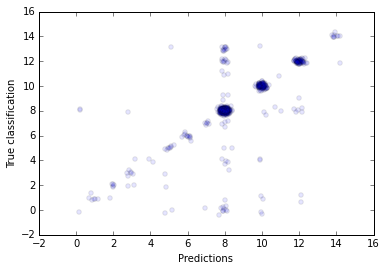

In [132]:
scores = []
n_neighbors = 15
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')

for train, test in KFold(len(y_train), n_folds=5):
    xtrain, xtest, ytrain, ytest = X_train[train], X_train[test], y_train[train], y_train[test]
    
    b = SelectKBest()
    b.fit(xtrain, ytrain)
    xtrain = xtrain[:, b.get_support()]
    xtest = xtest[:, b.get_support()]

    clf.fit(xtrain, ytrain)
    scores.append(clf.score(xtest, ytest))

print "K (15) Nearest Neighbors average accuracy:", np.mean(scores)

print "\nSample KNN:"
knnpred = clf.predict(xtest)
accuracy_score(knnpred, ytest, display=False)

Much better at predicting other classes now! Still over-predicting class 8 though.

RF average accuracy: 0.871354240426

Sample RF:


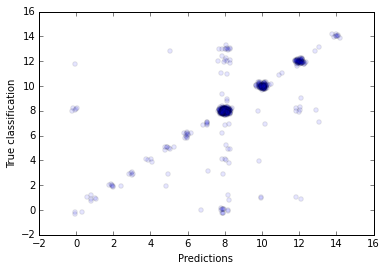

In [73]:
RF = RandomForestClassifier(n_estimators=50)
scores = []

for train, test in KFold(len(y_train), n_folds=5):
    xtrain, xtest, ytrain, ytest = X_train[train], X_train[test], y_train[train], y_train[test]
    
    b = SelectKBest()
    b.fit(xtrain, ytrain)
    xtrain = xtrain[:, b.get_support()]
    xtest = xtest[:, b.get_support()]

    RF.fit(xtrain, ytrain)
    scores.append(RF.score(xtest, ytest))

print "RF average accuracy:", np.mean(scores)

print "\nSample RF:"
rfpred = RF.predict(xtest)
accuracy_score(rfpred, ytest, display=False)

Overall slightly better, but now seems to overpredict 0 and 8 even more than before (although correcting for other categories).

Extra Trees Classifier average accuracy: 0.873295463486

Sample ETC:


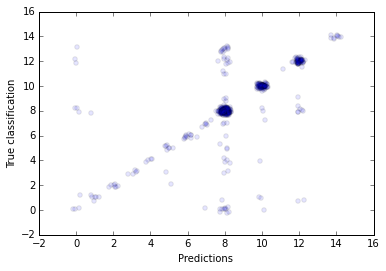

In [74]:
ETC = ExtraTreesClassifier(n_estimators=50)
scores = []

for train, test in KFold(len(y_train), n_folds=5):
    xtrain, xtest, ytrain, ytest = X_train[train], X_train[test], y_train[train], y_train[test]
    
    b = SelectKBest()
    b.fit(xtrain, ytrain)
    xtrain = xtrain[:, b.get_support()]
    xtest = xtest[:, b.get_support()]

    ETC.fit(xtrain, ytrain)
    scores.append(ETC.score(xtest, ytest))

print "Extra Trees Classifier average accuracy:", np.mean(scores)

print "\nSample ETC:"
etcpred = ETC.predict(xtest)
accuracy_score(etcpred, ytest, display=False)

Almost indistinguishable from regular Random Forest.

Gaussian Naive Bayes average accuracy: 0.119892160102

Sample GNB:


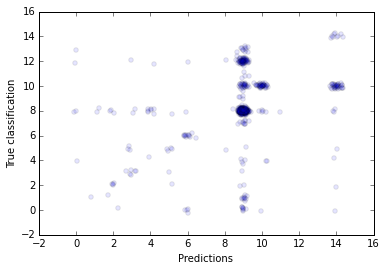

In [75]:
gnb = GaussianNB()
scores = []

for train, test in KFold(len(y_train), n_folds=5):
    xtrain, xtest, ytrain, ytest = X_train[train], X_train[test], y_train[train], y_train[test]
    
    b = SelectKBest()
    b.fit(xtrain, ytrain)
    xtrain = xtrain[:, b.get_support()]
    xtest = xtest[:, b.get_support()]

    gnb.fit(xtrain, ytrain)
    scores.append(gnb.score(xtest, ytest))

print "Gaussian Naive Bayes average accuracy:", np.mean(scores)

print "\nSample GNB:"
gnb1pred = gnb.predict(xtest)
accuracy_score(gnb1pred, ytest, display=False)

This model is really bad. We believe that it doesn't work well because the distribution of each column of X is not actually distribution Gaussian. Perhaps it would work better if we normalized the distribution of each column of X. For some reason it also looks like everything that was supposed to be predicted 8 was actually predicted 9? Really strange. We don't know why that happened.

Gaussian Naive Bayes average accuracy: 0.339207880285

Sample GNB2:


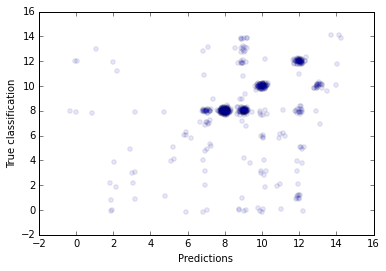

In [76]:
X_new = np.apply_along_axis(normalize1, 1, X_train)

gnb2 = GaussianNB()
scores = []

for train, test in KFold(len(y_train), n_folds=5):
    xtrain, xtest, ytrain, ytest = X_new[train], X_new[test], y_train[train], y_train[test]
    
    b = SelectKBest()
    b.fit(xtrain, ytrain)
    xtrain = xtrain[:, b.get_support()]
    xtest = xtest[:, b.get_support()]

    gnb2.fit(xtrain, ytrain)
    scores.append(gnb2.score(xtest, ytest))

print "Gaussian Naive Bayes average accuracy:", np.mean(scores)

print "\nSample GNB2:"
gnb2pred = gnb2.predict(xtest)
accuracy_score(gnb2pred, ytest, display=False)

A quick attempt to normalize our results is unsuccessful. 

Accuracy: 0.719332679097


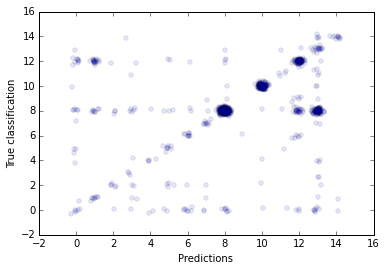

In [95]:
def getIndicator(data) :
    nFeatures = data.shape[1]
    newdata = np.matrix((data[:,0] == 0).astype(int)).T
    for i in range(1, nFeatures) :
        newcol = (data[:,i] == 0).astype(int)
        newdata = np.append(newdata, np.matrix(newcol).T, axis=1)
    return newdata

X_only_ind = getIndicator(X_train)
X_ind_train, X_ind_test, y_ind_train, y_ind_test = cv.train_test_split(X_only_ind, y_train, test_size = 0.33, random_state=32)

from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_ind_train, y_ind_train)
y_pred=bnb.predict(X_ind_test)
accuracy_score(y_pred,y_ind_test)

If we convert our X matrix to indicator variables only, then we can also try naive bayes with a binomial distribution. It performs much better than the Gaussian assumption, but not very promising.

In [77]:
from collections import defaultdict
import scipy.stats as dist
import math

def separateByClass(xdata, ydata) :
    separated = defaultdict()
    uniqueClasses = np.unique(ydata)
    for i in uniqueClasses :
        separated[i] = xdata[ydata == i,:]
    return separated

def summarize(matrix) :
    return [(np.mean(attribute), np.std(attribute)) for attribute in zip(*matrix)]
    
def summarizeByClass(xdata, ydata) :
    separated = separateByClass(xdata, ydata)
    summaries = defaultdict()
    for i in separated.keys() :
        summaries[i] = summarize(separated[i])
    return summaries

def calculateProbability(kernel, x, mean, std) :
    if mean == 0 and kernel == 'poisson':
        mean += 0.01
        
    if std == 0 and kernel == 'normal':
        std += 1

    if kernel == 'poisson' :
        return dist.poisson.pmf(x, mean)
    elif kernel == 'normal' :
        return dist.norm.pdf(x, mean, std)
    elif kernel == 'expo' :
        return dist.expon.pdf(x)
    
def calculateClassProbability(kernel, summaries, inputVector) :
    probabilities = defaultdict()
    for classValue, classSummaries in summaries.iteritems() :
        probabilities[classValue] = 1
        for i in range(len(classSummaries)) :
            mean, std = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calculateProbability(kernel, x, mean, std)
    
    '''sumProb = np.sum(probabilities.values())
    for key, value in probabilities.items():
        probabilities[key] = value / float(sumProb)'''
    
    return probabilities

def predict(kernel, summaries, inputVector) :
    probabilities = calculateClassProbability(kernel, summaries, inputVector)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.iteritems() :
        if bestLabel is None or probability > bestProb :
            bestProb = probability
            bestLabel = classValue
    return bestLabel

def getPredictions(kernel, xtrain, ytrain, xtest) :
    summaries = summarizeByClass(xtrain, ytrain)
    
    predictions = []
    for i in range(xtest.shape[0]) :
        result = predict(kernel, summaries, xtest[i,:])
        predictions.append(result)
    return predictions

Accuracy: 0.223748773307
CPU times: user 1min 39s, sys: 439 ms, total: 1min 39s
Wall time: 1min 39s


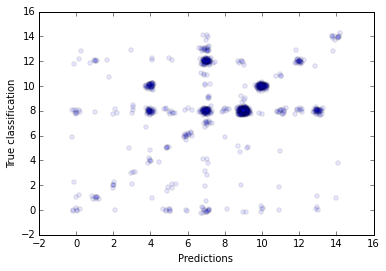

In [80]:
%%time
X_train_split, X_test_split, y_train_split, y_test_split = cv.train_test_split(X_train, y_train, test_size = 0.33, random_state=32)

gen1pred = getPredictions('normal', X_train_split, y_train_split, X_test_split)
accuracy_score(gen1pred, y_test_split)

Accuracy: 0.765456329735
CPU times: user 1min 36s, sys: 318 ms, total: 1min 37s
Wall time: 1min 37s


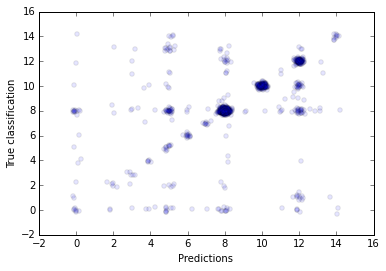

In [82]:
%%time
X_norm = np.apply_along_axis(normalize1, 1, X_train)
X_norm_train, X_norm_test, y_norm_train, y_norm_test = cv.train_test_split(X_norm, y_train, test_size = 0.33, random_state=32)

gen2pred = getPredictions('normal', X_norm_train, y_norm_train, X_norm_test)
accuracy_score(gen2pred, y_test_split)

At first, the generative model doesn't seem to do much better (since the columns are still not distributed Gaussian). After we "normalize" the columns a bit, we actually have a decent prediction, but it vastly overpredicts 12 for some reason (as well as missing a lot of 8s, which has never happened before).

In [85]:
X_train_split, X_test_split, y_train_split, y_test_split = cv.train_test_split(X_train, y_train, test_size = 0.33, random_state=32)

In [90]:
def get_score(arr1, arr2) :
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    
    if arr1.shape == arr2.shape :
        return len(np.where(arr1 == arr2)[0])/float(arr1.shape[0])

(0.8773307163886163, 14)
Accuracy: 0.878312070658


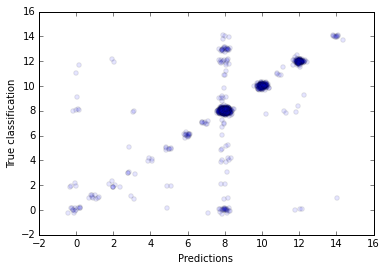

In [93]:
from sklearn.ensemble import ExtraTreesClassifier

#test optimal maximun depth
max_xtr_score=0
opt_max_depth=0
for i in range(5,20):
    xtr=ExtraTreesClassifier(n_estimators=50,max_depth=i)
    xtr=xtr.fit(X_train_split,y_train_split)
    y_ind_pred=xtr.predict(X_test_split)
    if get_score(y_ind_pred, y_test_split)>max_xtr_score:
            max_xtr_score=get_score(y_ind_pred, y_test_split)
            opt_xtr_depth=i
print(max_xtr_score,opt_xtr_depth)

clf = ExtraTreesClassifier(n_estimators=50,max_depth=opt_xtr_depth)
clf = clf.fit(X_train_split, y_train_split)
y_pred = clf.predict(X_test_split)
accuracy_score(y_pred, y_test_split)

Looks like we were able to bump up our ETC score a bit, although we're still over predicting 8 pretty heavily.

Accuracy: 0.862610402355


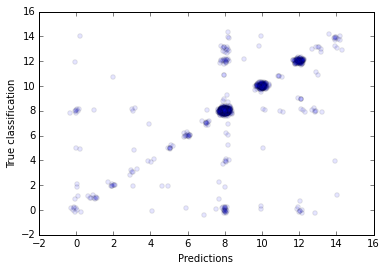

In [94]:
from sklearn.ensemble import GradientBoostingClassifier

gbc=GradientBoostingClassifier(n_estimators=50)
gbc=gbc.fit(X_train_split,y_train_split)
y_pred=gbc.predict(X_test_split)
accuracy_score(y_pred,y_test_split)

Gradient boosting doesn't help too much - we gain accuracy in predicting 8 at the cost of incorrectly predicting 0 and 12.

# Going in a different direction ...

Since none of our models were doing particularly well in the Kaggle competition, we wanted to try going in a new direction - looking at that the XML files themselves and trying to find patterns. There was some success here - we realized rapidly that we were able to rapidly visually identify viruses (their logs looked nearly identical sometimes!) by their processes or commands.

What if, therefore, we might be able to calculate the similarity of these logged process vectors? If two viruses had nearly identical logged process vectors, we might be able to assume that they are the same virus! Therefore we can compare the testing dataset with the training dataset, for which we have correct labels. The algorithm below tries to accomplish this by calculating the longest identical subvector between two vectors; the greater the ratio max$\left(\frac{len(subvec_{ij})}{len(vec_i)}\right)$, the more likely that these vectors are of the same class. 

In [108]:
import os
import util
from scipy import sparse
import numpy as np
from collections import Counter
import pandas as pd
import random
from matplotlib import pyplot as plt
from sklearn import cross_validation as cv

try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET

def check_all(start_index, end_index, direc):
    classes = []
    ids = [] 
    processes = []
    i = -1
    for datafile in os.listdir(direc):
        if datafile == '.DS_Store':
            continue

        i += 1
        if i < start_index:
            continue 
        if i >= end_index:
            break
        
        # extract id and true class (if available) from filename
        id_str, clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))

        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)

        tree = ET.parse(os.path.join(direc,datafile))
        root = tree.getroot()
        
        processList = []
        for child in root :
            if type(child) is not str :
                if 'filename' in child.attrib.keys() :
                    processList.append(child.attrib['filename'])
        processes.append(processList)
        
        '''processList = []
        for el in tree.iter() :
            processList.append(el.tag)
        processes.append(processList)'''

    return np.array(classes), ids, processes

In [109]:
y, ids, processes = check_all(0, 3086, 'train')
train_proc, test_proc, y_train, y_test = cv.train_test_split(processes, y, test_size = 0.33, random_state=32)
train_lengths = [len(proc) for proc in train_proc]

df = pd.DataFrame()
df['class'] = y_train
df['lengths'] = train_lengths

In [110]:
def contains_sublist(lst, sublst):
    n = len(sublst)
    return any([(sublst == lst[i:i+n]) for i in xrange(len(lst)-n+1)])

def substring(n,m,minLength=5) :
    start = 0
    while start < len(n) - 5 :
        exists = contains_sublist(m, n[start:start+minLength])
        while exists == True and (start + minLength) < len(n):
            exists = contains_sublist(m, n[start:start+minLength])
            if exists == True :
                minLength += 1
        start += 1
    return (minLength - 1)/float(len(n))

def most_common(lst):
    return max(set(lst), key=lst.count)

def capMask(old_vector, limit) :
    vector = old_vector[:]
    if np.sum(vector) > limit :
        falseMask = random.sample(np.where(np.array(vector) == True)[0].tolist(), (np.sum(vector) - limit))
        for sample in falseMask :
            vector[sample] = False
        return vector
    else :
        return vector

def bestMatch(unknown, allProcesses, lengths, y, df, minLength, error) :
    u_length = len(unknown)
    mask = [True if (length-error) <= u_length <= (length+error) else False for length in lengths]
    
    if np.sum(mask) == 1 :
        return [el[1] for el in zip(mask,y) if el[0] == True][0]
    elif u_length < 1500 :
        new_mask = capMask(mask, 20)
        dftouse = df[new_mask]
        processtouse = [el[1] for el in zip(new_mask,allProcesses) if el[0] == True]

        withScores = dftouse.copy()
        withScores['scores'] = [substring(unknown, process) for process in processtouse]
        topClasses = withScores[withScores.scores > 0.75].sort(['scores'], ascending=False)['class'].tolist()
        if len(topClasses) > 0 :
            return most_common(topClasses)
        else :
            return -1
    else :
        return -1

In [117]:
train_pred = []
    
start = len(train_pred)
for i in range(start,len(test_proc)) :
    if i%100==0 :
        print i
    train_pred.append(bestMatch(test_proc[i], train_proc, train_lengths, y_train, df, minLength=5, error=0))
    np.save('train_pred.npy',np.array(train_pred))

0
100
200
300
400
500
600
700
800
900
1000


In [112]:
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def accuracy_score(arr1, arr2) :
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    
    if arr1.shape == arr2.shape :
        print 'Accuracy: ' + str(len(np.where(arr1 == arr2)[0])/float(arr1.shape[0]))
    
    plt.scatter(rand_jitter(arr1), rand_jitter(arr2), alpha=0.1);
    plt.xlabel('Predictions');
    plt.ylabel('True classification');

Accuracy: 0.551521099117


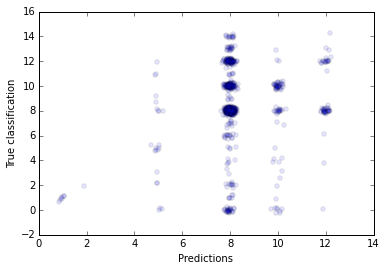

In [118]:
%matplotlib inline
train_pred = np.load('train_pred.npy')
y_pred = [int(el) if el != -1 else 8 for el in train_pred.tolist()]
n = len(y_pred)
accuracy_score(np.array(y_pred),y_test[0:n])

# Looking for more features ...

In [133]:
def viewProcess(datafile) :
    direc = 'train'
    tree = ET.parse(os.path.join(direc,datafile))
    for el in tree.iter():
        print el.tag

In [134]:
# Allow you to check the filenames of a file name
# Need to use the FULL filename including .class.xml
def viewProcessNames(datafile) :
    direc = 'train'
    root = ET.parse(os.path.join(direc,datafile)).getroot()

    for child in root :
        if type(child) is not str :
            if 'filename' in child.attrib.keys() :
                print child.attrib['filename']

In [135]:
# Just run this, you don't need to modify anything 
# Basically this function applies the checking function against part
# or all of the training matrix
def check_all(start_index, end_index, direc, func):
    X = None
    classes = []
    ids = [] 
    i = -1
    for datafile in os.listdir(direc):
        if datafile == '.DS_Store':
            continue

        i += 1
        if i < start_index:
            continue 
        if i >= end_index:
            break
        
        # extract id and true class (if available) from filename
        id_str, clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))

        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)

        tree = ET.parse(os.path.join(direc,datafile))
        this_row = func(tree)
        if X is None:
            X = this_row
        else:
            X = np.vstack((X, this_row))

    return X, np.array(classes), ids

In [137]:
# Checks the accuracy of your technique!
# Substitute the correct class integer and your checking function
# See below for an example
def accuracyRate(func, correctClass=0, n=100) :
    X_train, y_train, ids = check_all(0,n,'train',func)

    pred = [el[0] for el in X_train.tolist()]
    isActual = y_train == correctClass

    df = pd.DataFrame()
    df['id'] = ids
    df['pred'] = pred
    df['actual'] = isActual.tolist()
    df['realClass'] = y_train
    df['correct'] = df['actual'] == df['pred']
    
    print "False Positives Rate: " + str(len(df.loc[(df['actual'] == False) & (df['pred'] == True)])/float(n))
    print "False Negative Rate: " + str(len(df.loc[(df['actual'] == True) & (df['pred'] == False)])/float(n))
    print "Correct ID Rate: " + str(len(df.loc[df['correct'] == True])/float(n))
    print ""
    return df

def viewFalseN(df) :
    return df.loc[(df['actual'] == True) & (df['pred'] == False)]

def viewFalseP(df) :
    return df.loc[(df['actual'] == False) & (df['pred'] == True)]

def viewCorrect(df) :
    return df.loc[(df['actual'] == True) & (df['pred'] == True)]

In [153]:
# Write a function which takes an XML root and returns True/False
# Should evaluate whether or not it is part of a malware class
def check_swizzor(tree) :
    root = tree.getroot()
    process = []
    for child in root :
        if type(child) is not str :
            if 'filename' in child.attrib.keys() :
                process.append(child.attrib['filename'])
        
    for i in range(len(process) - 1) :
        first = process[i]
        second = process[i+1]
        
        if "iexplore.exe" in first and ("services.exe" in second or "svchost.exe" in second):
            return True
            break
    
    return False

df = accuracyRate(func=check_swizzor, correctClass=10, n=3086)

False Positives Rate: 0.00810110174984
False Negative Rate: 0.00324044069994
Correct ID Rate: 0.98865845755



In [145]:
# Write a function which takes an XML root and returns True/False
# Should evaluate whether or not it is part of a malware class
def check_VB2(tree) :
    root = tree.getroot()
    tags = []
    process = []
    
    for el in tree.iter() :
        tags.append(el.tag)

    for child in root :
        if type(child) is not str :
            if 'filename' in child.attrib.keys() :
                process.append(child.attrib['filename'])
    
    for i in range(len(tags) - 1) :
        first = tags[i]
        second = tags[i+1]
        
        if "destroy_window" in first and "destroy_window" in second :
            if len(process) == 1 :
                return True
                break
    
    return False

df = accuracyRate(func=check_VB2, correctClass=12, n=3086)

False Positives Rate: 0.0301360985094
False Negative Rate: 0.0408295528192
Correct ID Rate: 0.929034348671



In [146]:
# Write a function which takes an XML root and returns True/False
# Should evaluate whether or not it is part of a malware class
def check_autorun(tree) :
    root = tree.getroot()
    
    tags = []
    process = []
    
    for child in root :
        if type(child) is not str :
            if 'filename' in child.attrib.keys() :
                process.append(child.attrib['filename'])
    
    keywords = ['taskkill']
    
    for i in range(len(process)) :
        for word in keywords :
            if word in process[i] :
                return True
                break
    
    return False

df = accuracyRate(func=check_autorun, correctClass=1, n=3086)

False Positives Rate: 0.00194426441996
False Negative Rate: 0.00745301360985
Correct ID Rate: 0.99060272197

